In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from itertools import combinations

### My Attempt at the beginner Titanic challenge on Kaggle

In [2]:
traindf = pd.read_csv('/kaggle/input/titanic/train.csv')
testdf = pd.read_csv('/kaggle/input/titanic/test.csv')
gendersubmissiondf = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
traindf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Step 1: EDA

In [3]:
# We start by checking for null values
trainMissing = set()
testMissing = set()

for col in traindf.columns:
    if traindf[col].isnull().any():
        trainMissing.add(col)
    if col != 'Survived' and testdf[col].isnull().any():
            testMissing.add(col)
        
print(f"Train Data has missing values for: {trainMissing}")
print(f"Test data has missing values for: {testMissing}")

Train Data has missing values for: {'Cabin', 'Age', 'Embarked'}
Test data has missing values for: {'Cabin', 'Fare', 'Age'}


### Categorical Data

In [4]:
def categoricalHist(infodf, feature: str, axis=None, title=True):
    '''
    Helper Function that plots Survived vs non-Survived for categorical features
    Takes input arguments: 
    infodf: Dataframe (data must contain label values)
    feature: Categorical Feature to be queried
    title: Flag that allows user to disable title
    '''
    
    survival_counts = pd.crosstab(infodf[feature], infodf['Survived'])

    # Create the plot
    if axis is None:
        plt.figure(figsize=(10, 6))
        survival_counts.plot(kind='bar', color=['orange', 'navy'])
    
        if title:
            plt.title(f'Survival counts by {feature}', fontsize=16)
        
        plt.xlabel(feature, fontsize=14)
        plt.ylabel('Count', fontsize=14)
        plt.xticks(rotation=45)
        plt.legend(['Did Not Survive', 'Survived'])
        plt.tight_layout()
        plt.show()
    else:
        survival_counts.plot(kind='bar', color=['orange', 'navy'], ax=axis)
        
        if title:
            axis.set_title(f'Survival counts by {feature}', fontsize=16)
    
        axis.set_xlabel(feature, fontsize=14)
        axis.set_ylabel('Count', fontsize=14)
        axis.tick_params(axis='x', rotation=45)
        axis.legend(['Did Not Survive', 'Survived'])

def plot_confusion_matrix(y_true, y_pred, figsize=(8,6), class_names=None, tl=''):
    '''
    Function that plots confusion matrix of data, given input of 
    predicted labels and true labels. Make sure to import the following:
    from sklearn.metrics import confusion_matrix
    '''


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    
    if class_names is None:
        class_names = ['Not Survived', 'Survived'] 
    
    plt.xticks(np.arange(len(class_names)) + 0.5, class_names)
    plt.yticks(np.arange(len(class_names)) + 0.5, class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(tl + ' Confusion Matrix')
    plt.tight_layout()
    plt.show()

Text(0.5, 0.98, 'Titanic Survival Analysis by Different Features')

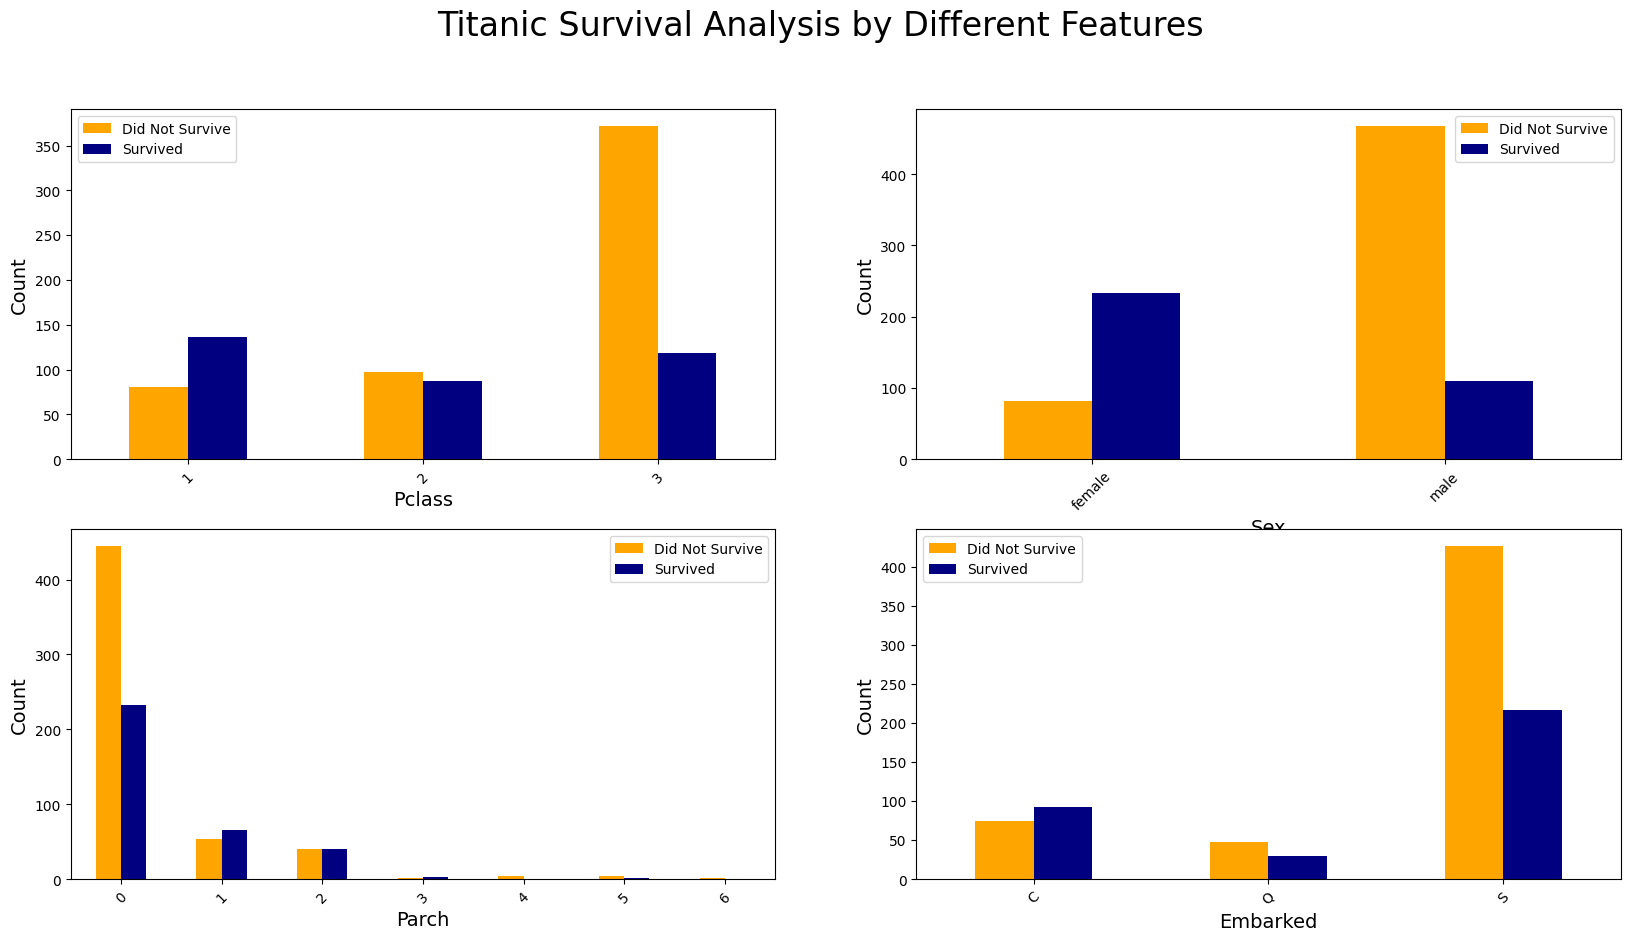

In [5]:
categoricalFeatures = ['Pclass', 'Sex', 'Parch', 'Embarked']
fig,ax=plt.subplots(2,2,figsize=(20,10))
ax=ax.flatten()

for i, feature in enumerate(categoricalFeatures):
    categoricalHist(traindf, feature, axis=ax[i], title=False)

fig.suptitle('Titanic Survival Analysis by Different Features', fontsize=24)


There is some significant information to be found here. First, it's notable that a much higher proportion of Females survived instead of Males. For Parch 0, a much higher proportion of people did not survive. Those passengers who embarked at 'S' (Southampton) also had a significantly lower survival rate compared to other embarking points. At Pclass 3, a lower proportion of people had survived too. I want to make some PMFs of these features against each other to see if there are any insights to be revealed.

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


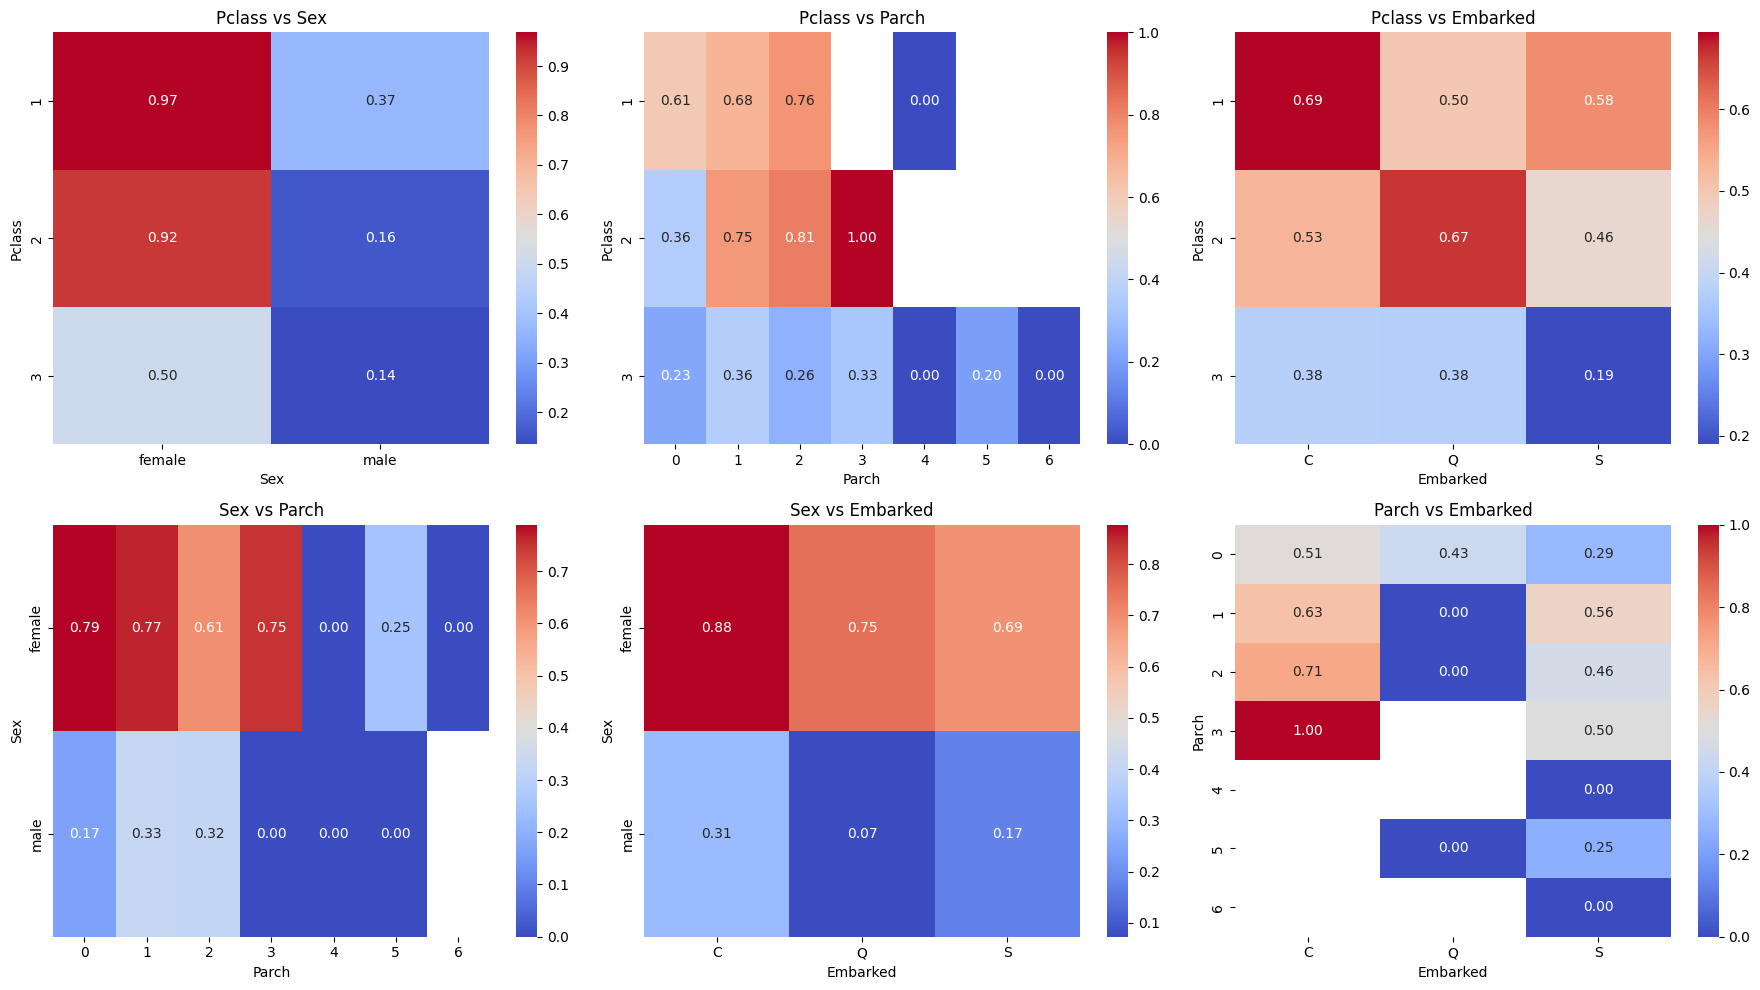

In [6]:
def plot_survival_heatmaps(infodf, categorical_features):
    pairs = list(combinations(categorical_features, 2))
    n = len(pairs)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, (feat1, feat2) in enumerate(pairs):
        pmf = infodf.groupby([feat1, feat2])['Survived'].mean().unstack()
        sns.heatmap(pmf, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[i])
        axes[i].set_title(f"{feat1} vs {feat2}")
        axes[i].set_xlabel(feat2)
        axes[i].set_ylabel(feat1)
    
    plt.tight_layout()
    plt.show()

plot_survival_heatmaps(traindf, categoricalFeatures)

From these heatmaps, I notice that Sex, Pclass and Parch all can have significant meaning towards or model prediction. Luckily, we do not have any missing values for these features. The warning above occur due to the missing values in Embarked. Looking at these graphs, I'm quite happy to convert Embarked to numeric ({-1, 0, 1}) and impute the mean for the missing values. I'm also very iterested in engineering some features, especially with Sex, as the correllation heatmaps show stronger relationships than the earlier barchart, especially for Sex vs Parch and Pclass vs Sex.

### Quantitative data

In [7]:
# For now, we do not utilize the features: Name, Cabin and Ticket.
QuantitativeFeatures = ['Age', 'Fare', 'SibSp']


#plt.scatter(x=traindf['Age'],y=traindf['Fare'])
#plt.grid(alpha=0.7)
#plt.show()

def quantitativeScatter(infodf, feature1: str, feature2: str, axis=None, title=True):
    '''
    Helper Function that plots Survived vs non-Survived for two quantitative features
    Takes input arguments: 
    infodf: Dataframe (data must contain label values)
    feature: Quantitative Feature to be queried
    title: Flag that allows user to disable title of subplots
    '''
    
    # Create the plot
    if axis is None:
        plt.figure(figsize=(8,6))
        sns.scatterplot(data=infodf, x=feature1, y=feature2, hue='Survived', palette={0: 'red', 1: 'green'})

        if title:
            plt.title(f'{feature1} vs {feature2} coloured by Survival')
        
        #plt.xlabel(feature, fontsize=14)
        #plt.ylabel('Count', fontsize=14)
        plt.grid(True)
        plt.show()
        
    else:
        sns.scatterplot(data=infodf, x=feature1, y=feature2, hue='Survived', palette={0: 'red', 1: 'green'}, ax=axis)
        
        if title:
            axis.set_title(f'{feature1} vs {feature2} coloured by Survival')


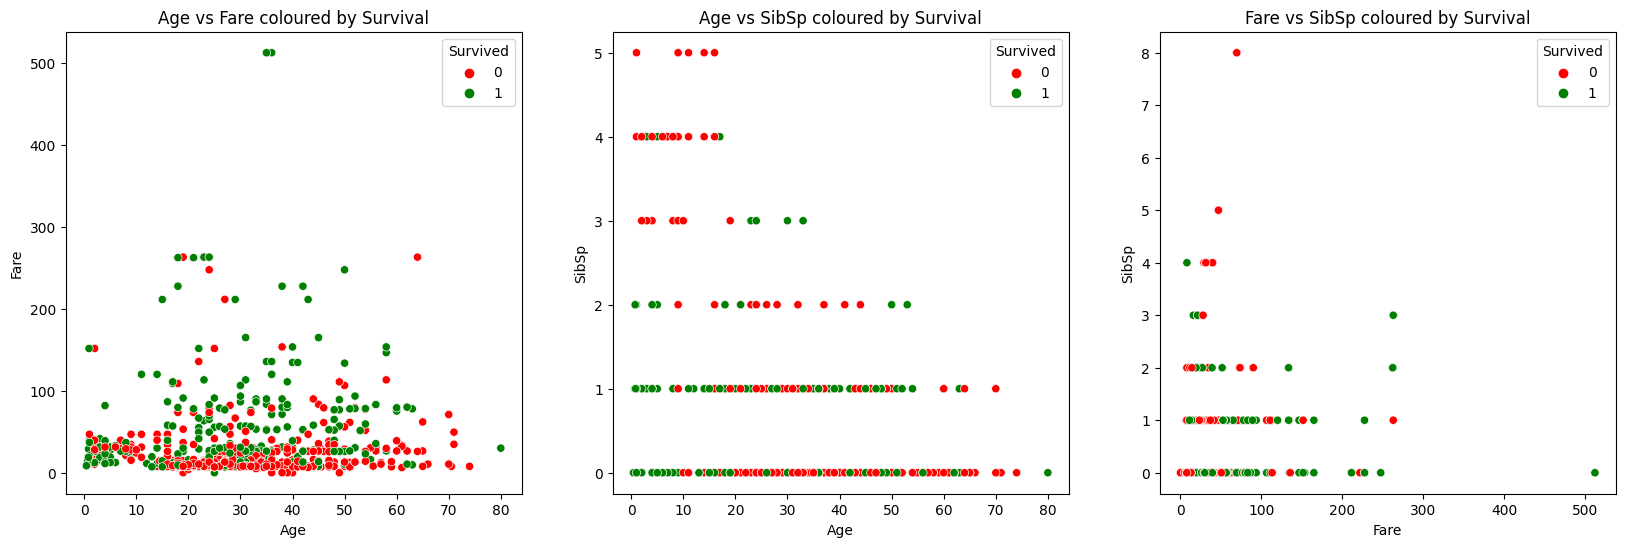

In [8]:
fig,ax=plt.subplots(1,3,figsize=(20,6))
for i, feature in enumerate(combinations(QuantitativeFeatures, 2)):
    quantitativeScatter(traindf, feature[0], feature[1], axis=ax[i])
plt.show()
    

While it may be difficult to directly extract our labels from these plots, we can see some trends, like very young passengers (like children) having much higher chances of survival. This makes sense, as people prioritize saving children during such events.
It's also noted low-fare paying surviving less than those who paid higher fares.

TODO: I want to try plotting Sex against these features to see if I can find any strong relationships

In [9]:
#fig,ax=plt.subplots(1,3,figsize=(20,6))
#for i, feature in enumerate(QuantitativeFeatures):   
    #ax[i].hist(traindf[feature], bins=8)
    #ax[i].set_xlabel(feature)
    #ax[i].set_ylabel('Survival Count')

#plt.show()

Here we see Something convicing. ALL high fare paying Females Survived, whereas for males, those who paid a lower fare had a higher chance of survival. Also, Interestingly, young girls had a lower chance of surviving than women of other age groups, whereas the opposite is true for men. This is quite a curious observation...

### Cleaning missing values in train data 'Embarked'

In [10]:
mappingEmbarked = {'C': 1, 'Q': 2, 'S': 3}
# Convert to numeric, then impute mean
traindf['Embarked_numeric'] = traindf['Embarked'].map(mappingEmbarked)

# Note that test df does not have missing values for Embarked
testdf['Embarked_numeric'] = testdf['Embarked'].map(mappingEmbarked)

traindf['Embarked_numeric'].unique()

array([ 3.,  1.,  2., nan])

In [11]:
trainMissing = set()
testMissing = set()

for col in traindf.columns:
    if traindf[col].isnull().any():
        trainMissing.add(col)
    if col != 'Survived' and testdf[col].isnull().any():
            testMissing.add(col)
        
print(f"Train Data has missing values for: {trainMissing}")
print(f"Test data has missing values for: {testMissing}")

Train Data has missing values for: {'Cabin', 'Embarked_numeric', 'Age', 'Embarked'}
Test data has missing values for: {'Cabin', 'Fare', 'Age'}


# Impute missing values, and convert categorical data to numeric
We impute missing values in this next step. Both train and test data contain missing values for Age. The train data also has missing values for Embarked, and the test data has missing values for Fare

In [12]:
# mean fill Embarked in train data
traindf['Embarked_numeric'] = traindf['Embarked_numeric'].fillna(traindf['Embarked_numeric'].mean())

# mean fill train and test for Age
traindf['Age'] = traindf['Age'].fillna(traindf['Age'].mean())
testdf['Age'] = testdf['Age'].fillna(testdf['Age'].mean())

# median fill fare for test data
testdf['Fare'] = testdf['Fare'].fillna(testdf['Fare'].median())

# Feature Engineering

In this stage, we most importantly stadardise our data to have 0 mean and unit standard deviation. We also Engineer two new features, that take the relationship of Sex, Pclass, Parch and Embarked and Age which will help to differentiate Surviving Passengers from non-surviving ones.

In [13]:
#TODO: Engineer said features
#TODO: Utilise Cabin

### Scaling

In [14]:
scaler = StandardScaler()

# Pclass
traindf['Pclass_transformed'] = scaler.fit_transform(traindf['Pclass'].values.reshape(-1,1))
testdf['Pclass_transformed'] = scaler.fit_transform(testdf['Pclass'].values.reshape(-1,1))

# Sex
# I do not standardise the values for sex becuase I want the difference to be very distinct
traindf['Sex_transformed'] = traindf['Sex'].map({'female': 1, 'male': -1})
testdf['Sex_transformed'] = testdf['Sex'].map({'female': 1, 'male': -1})

# Age
traindf['Age_transformed'] = scaler.fit_transform(traindf['Age'].values.reshape(-1,1))
testdf['Age_transformed'] = scaler.fit_transform(testdf['Age'].values.reshape(-1,1))

# SibSp
traindf['SibSp_transformed'] = scaler.fit_transform(traindf['SibSp'].values.reshape(-1,1))
testdf['SibSp_transformed'] = scaler.fit_transform(testdf['SibSp'].values.reshape(-1,1))

# Parch
traindf['Parch_transformed'] = scaler.fit_transform(traindf['Parch'].values.reshape(-1,1))
testdf['Parch_transformed'] = scaler.fit_transform(testdf['Parch'].values.reshape(-1,1))

# Fare
traindf['Fare_transformed'] = scaler.fit_transform(traindf['Fare'].values.reshape(-1,1))
testdf['Fare_transformed'] = scaler.fit_transform(testdf['Fare'].values.reshape(-1,1))

# Embarked (numeric)
traindf['Embarked_transformed'] = scaler.fit_transform(traindf['Embarked_numeric'].values.reshape(-1,1))
testdf['Embarked_transformed'] = scaler.fit_transform(testdf['Embarked_numeric'].values.reshape(-1,1))

# Cabin
# Replace Null values with class 'N'
traindf['Cabin_transformed'] = traindf['Cabin'].apply(lambda x: x[0] if isinstance(x, str) and len(x) > 0 else 'N')
testdf['Cabin_transformed'] = testdf['Cabin'].apply(lambda x: x[0] if isinstance(x, str) and len(x) > 0 else 'N')

# Assign numeric values to each Cabin class
survival_rates_by_Cabin = traindf.groupby('Cabin_transformed')['Survived'].mean().sort_values(ascending=False).index.tolist()
cabin_encodings = {C: i for i, C in enumerate(survival_rates_by_Cabin)}
traindf['Cabin_transformed'] = traindf['Cabin_transformed'].map(cabin_encodings)
testdf['Cabin_transformed'] = testdf['Cabin_transformed'].map(cabin_encodings)

traindf['Cabin_transformed'] = scaler.fit_transform(traindf['Cabin_transformed'].values.reshape(-1,1))
testdf['Cabin_transformed'] = scaler.fit_transform(testdf['Cabin_transformed'].values.reshape(-1,1))


# Condition: Females who Embarked at port 'C' (Cherbourg) had a higher chance of survival
engineered_sex_embarked_train = ((traindf['Sex_transformed'] == -1) * (traindf['Embarked'] == 'C') * -0.5) * traindf['Parch']
traindf['Sex_embarked_transform'] = traindf['Sex_transformed'] + engineered_sex_embarked_train

engineered_sex_embarked_test = ((testdf['Sex_transformed'] == -1) * (testdf['Embarked'] == 'C') * -0.5) * testdf['Parch']
testdf['Sex_embarked_transform'] = testdf['Sex_transformed'] + engineered_sex_embarked_test

# Attempt 1: Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

y_forest = traindf["Survived"]

features_forest = ['Pclass_transformed', 'Sex_transformed', 'SibSp_transformed', 'Fare_transformed', 'Age_transformed', 'Cabin_transformed']
X_forest = pd.get_dummies(traindf[features_forest])
X_test_forest = pd.get_dummies(testdf[features_forest])

model = RandomForestClassifier(n_estimators=1000, max_depth=10,min_samples_split=5,random_state=42)
model.fit(X_forest, y_forest)
predictions_forest = model.predict(X_test_forest)

output_forest = pd.DataFrame({'PassengerId': testdf.PassengerId, 'Survived': predictions_forest})
output_forest.to_csv('submission.csv', index=False)

Training Accuracy: 0.9091


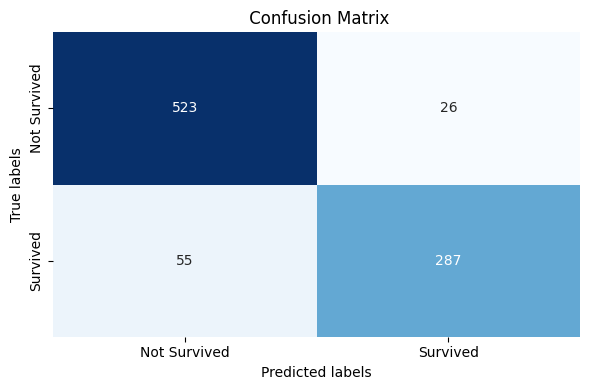

In [16]:
y_train_forest_pred = model.predict(X_forest)
y_test_forest_pred = model.predict(X_test_forest)
# Calculate accuracy
train_accuracy_forest = accuracy_score(y_forest, y_train_forest_pred)
print(f"Training Accuracy: {train_accuracy_forest:.4f}")
plot_confusion_matrix(y_forest, y_train_forest_pred, figsize=(6,4))

# Attempt 2: MLP

In [17]:
# Initialise MLP
import torch
from torch import nn

class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()

        self.activations = []
        self.gradients = []
        self.layer_names = []  # keep track of layer names for plotting

        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            linear = nn.Linear(layer_sizes[i], layer_sizes[i+1])
            self.layers.append(linear)
            self.layer_names.append(f"Linear {i}")
            
            tanh = nn.Tanh()
            self.layers.append(tanh)
            self.layer_names.append(f"Tanh {i}")

        # Final output layer
        final = nn.Linear(layer_sizes[-1], 2)
        self.layers.append(final)
        self.layer_names.append("Output Linear")

        self.model = nn.Sequential(*self.layers)
        self._register_hooks()

    def forward(self, x):
        self.activations = []
        self.gradients = []
        return self.model(x)
    
    def _register_hooks(self):
        for idx, layer in enumerate(self.model):
            # Activation hook for all layers
            layer.register_forward_hook(self._make_activation_hook(idx))

            # Only linear layers get gradient hooks
            if isinstance(layer, nn.Linear):
                layer.register_full_backward_hook(self._make_gradient_hook(idx))

    def _make_activation_hook(self, idx):
        def hook(module, input, output):
            self.activations.append(output.detach().cpu())
        return hook

    def _make_gradient_hook(self, idx):
        def hook(module, grad_input, grad_output):
            self.gradients.append(grad_output[0].detach().cpu())
        return hook

# Helper function to plot activations and gradients
def plot_individual_outputs(outputs, names, title_prefix, ylabel):
    for i, out in enumerate(outputs):
        plt.figure(figsize=(8, 4))
        plt.plot(out.flatten())
        plt.title(f"{title_prefix} - {names[i]}")
        plt.xlabel("Neuron Index")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [18]:
# train network
#features_MLP = ['Pclass_transformed', 'Sex_transformed', 'SibSp_transformed', 'Fare_transformed', 'Age_transformed', 'Parch_transformed', 'Embarked_transformed']
features_MLP = ['Pclass_transformed', 'Sex_embarked_transform', 'SibSp_transformed', 'Fare_transformed', 'Age_transformed', 'Parch_transformed', 'Cabin_transformed']

layer_sizes = [len(features_MLP), 32]

X_train_MLP = torch.tensor(traindf[features_MLP].values, dtype=torch.float32)
X_test_MLP = torch.tensor(testdf[features_MLP].values, dtype=torch.float32)
y_train_MLP = torch.tensor(traindf['Survived'].values, dtype=torch.int64)

# Use cross entropy loss and afame
model = MLP(layer_sizes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.006)

In [19]:
for X,y in zip(X_train_MLP, y_train_MLP):
   # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [20]:
model.eval()
with torch.no_grad():
    outputs = model(X_train_MLP)
    y_train_MLP_pred = torch.argmax(outputs, dim=1).tolist()

Training Accuracy: 0.8114


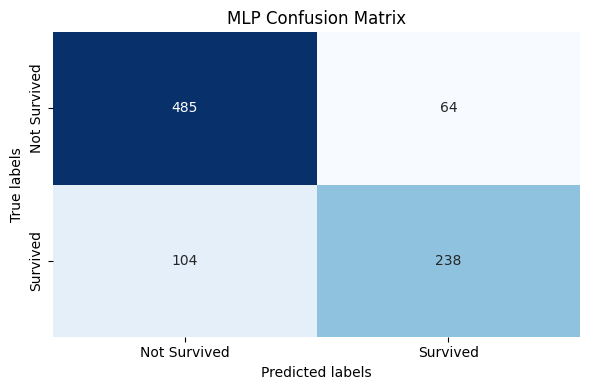

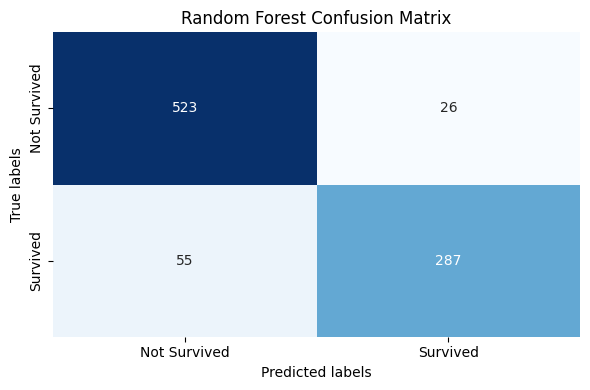

In [21]:
train_accuracy_MLP = accuracy_score(y_train_MLP, y_train_MLP_pred)
print(f"Training Accuracy: {train_accuracy_MLP:.4f}")
plot_confusion_matrix(y_train_MLP, y_train_MLP_pred, figsize=(6,4), tl='MLP')
plot_confusion_matrix(y_forest, y_train_forest_pred, figsize=(6,4), tl='Random Forest')

In [22]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_MLP)
    y_test_MLP_pred = torch.argmax(outputs, dim=1).tolist()

In [23]:
# Using output from random Forest or MLP
#submission_data_y_pred = y_test_forest_pred
submission_data_y_pred = y_test_MLP_pred
output_final = pd.DataFrame({'PassengerId': testdf.PassengerId, 'Survived': submission_data_y_pred})
output_final.to_csv('submission.csv', index=False)